<a href="https://colab.research.google.com/github/tgundavelli/Computer-Vision/blob/main/Automatic_Panorama_Mosaicing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Panorama Mosaicing

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

**bold text**### The cell below demonstrates feature detection (e.g. corners) and matching (e.g. BRIEF descriptor)

the number of matches is 56


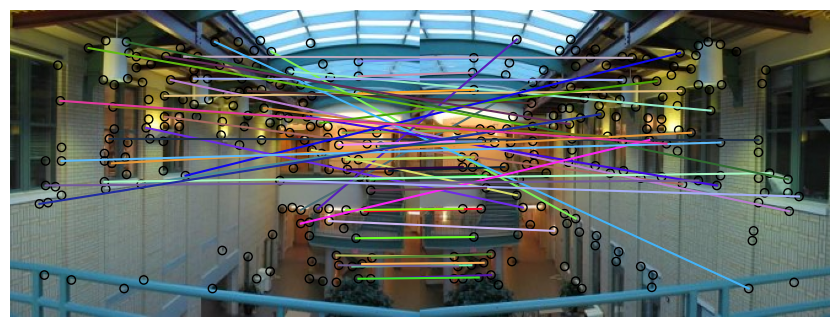

In [ ]:
import urllib.request
urllib.request.urlretrieve("http://mengtang.org/cse185/files/resource/CMU_left.jpg", "CMU_left.jpg")
urllib.request.urlretrieve("http://mengtang.org/cse185/files/resource/CMU_right.jpg", "CMU_right.jpg")

imL = image.imread("CMU_left.jpg")
imR = image.imread("CMU_right.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.0005, min_distance=5) #identifies prominent corner points
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.0005, min_distance=5) #not a cartesian coordinate system and instead a 2d array/matrix
#that is why (y,x) -> (rows,col) instead of (x,y) given that an image is a pixel grid

extractor = BRIEF() #BRIEF is a feature descriptor that generates a sequence of 0s and 1s to describe local image features, helpful for feature matching
#descriptor should be able to detect distinctive keypoint even under transformations, keypoint must be in a distinctive area

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask] #extractor.mask filters keypoints, assigning a boolean value to each keypoint, only valid keypoints pass
descriptorsL = extractor.descriptors #associates each keypoint with its respective feature descriptor

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]#remember there are two images : imL and imR
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)#performs feature matching b/t descriptors of keypoints in the two images

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))#number of rows is number of matches. number of cols is 2, each containing indices of matched keypoints

fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r') #visualizes keypoints and matches, imL is source image and imR is destination image
axA.axis('off')

plt.show()

## Problem 1
### Assume there are $N=56$ matches $(p,p')$ as in figure 1 above. $N_i=21$ of these matches are inliers for a homography, while the rest of the matches are $N_o=35$ outliers. To estimate a homography you need a sample with $K=4$ matches. What is the least number of times one should randomly sample a subset of $K$ matches to get probability  $p≥0.95$  that at least one of these samples has all of its $K$ matches from inliers? Derive a general formula and compute a numerical answer for the specified numbers.

### put your answer below
Solution:

 N = 56, Ni = 21 inliers, No = 35 outliers, p>= 0.95

k >= log(1-p) / log(1-w^n)
k >= log(1- 0.95) / log(1 - (21/56)^4) = 149.9850413

roughly at least 150 trials



### Problem 2: (RANSAC for Homographies)
### Write code below using RANSAC to estimate Homography from matched pairs of points above. This cell should display new figure 2 similar to figure 1 above, but it should show only inlier pairs for the detected homography. HINT: you can use $ProjectiveTransform$  from library $skimage$ declared at the top of the notebok. Use a residual_threshold of 3 for ProjectiveTransform.




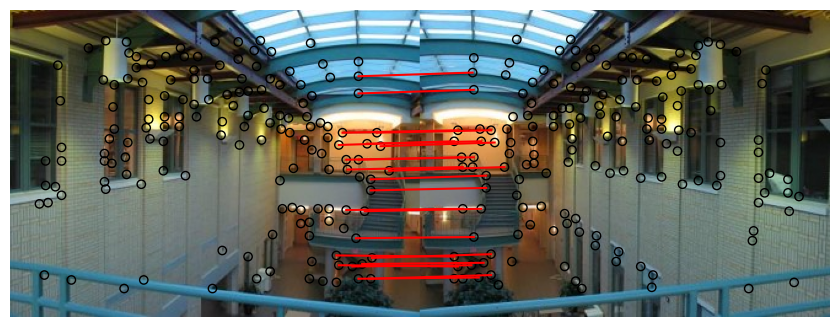

In [ ]:
#no need to use [:, ::-1] because already in (y,x) form
sourcept = keypointsL[matchesLR[:,0]] #first image is right image, 0 is indices of keypoints in 1st image that have matches, then retrieves the actual keypoints
destinationpt = keypointsR[matchesLR[:,1]] #second image is left image, 1 is indices of keypoints in 2nd image that have matches, then retrieves the actual keypoints

model_robust, inlier = ransac(((sourcept),(destinationpt)), ProjectiveTransform, min_samples=4, residual_threshold = 3, max_trials = 300)
#matchesLR contains information about the matches and matchesLR[inlier] filters out only reliable matches

fig = plt.figure(2,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR[inlier], matches_color = 'r')
#see how in the image above, the lines are slanted and not matching symmetrically. This image has correct matches and no false positives
axA.axis('off')

plt.show()

## Problem 3 (reprojecting onto common PP)
### Use common PP corresponding to the plane of the left image. Your pamorama mosaic should be build inside a "reference frame" (think about it as an empty canvas of certain size) inside this common PP. The reference frame should be big enough to contain the left image and the part of the view covered by the right image after reprojecting onto common PP. Create a new figure 3 including the following three images (spread them vertically). First, show your reference frame only with the left image inside. Second, show the reference frame containing only a reprojected right image (warp it using a homography computed in Problem 2). Third, for comparison, show the reference frame containing only the right image reprojected using a (bad) homography estimated from all matches (including outliers, as in figure 1).
#### HINT1: use function $warp$ from library $skimage$ declared at the top of the notebook.
#### HINT2: function $warp$ needs "inverse map" as a (second) argument as it uses "inverse warping" to compute output intensities

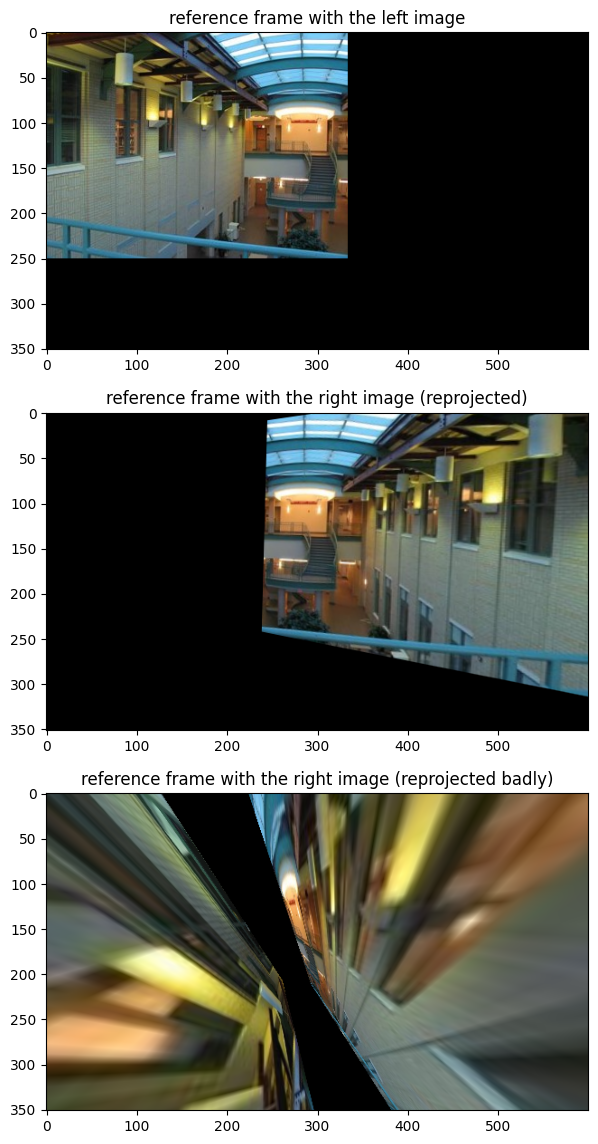

In [ ]:
#common PP refers to common principal point, reference point that both images share, point in space that serves as the center in which two images are
#aligned during creation of panaroma so they fit together correctly
#reference frame(RF) is a blank canvas where the panorama is built. output shape should be large enough

height = max(imL.shape[0],imR.shape[0])
width = imL.shape[1] + imR.shape[1]

tform = ProjectiveTransform(np.eye(3))

warped_imL = warp(imL, tform.inverse, output_shape = (351,600))

#tform = ProjectiveTransform(model_robust.params)
source = keypointsR[matchesLR[:, 1]]
destination = keypointsL[matchesLR[:, 0]]

model, inliers = ransac((np.fliplr(source),np.fliplr(destination)), ProjectiveTransform, min_samples=4, residual_threshold=3, max_trials=150)
warped_imR = warp(imR, model.inverse, output_shape = (351,600))

bad_tform = ProjectiveTransform() #doesn't use ransac
bad_tform.estimate(np.fliplr(source), np.fliplr(destination))
bad_warped_imR = warp(imR, bad_tform.inverse, output_shape = (351,600))

fig = plt.figure(3,figsize = (12, 14))
plt.subplot(311)
plt.imshow(warped_imL)
plt.title("reference frame with the left image")

plt.subplot(312)
plt.imshow(warped_imR)
plt.title("reference frame with the right image (reprojected)")

plt.subplot(313)
plt.imshow(bad_warped_imR)
plt.title("reference frame with the right image (reprojected badly)")

plt.show()

## Problem 4 (blending)

### (part a) Write code for a function below computing distance transform for the boundary of a given image. It returns a numpy array of the same size as the image with distances from each pixel to the closest point on the boundary of the image (float values).
   

In [ ]:
    def boundaryDT(image):
         height = image.shape[0]
         width = image.shape[1]
         distances = np.zeros((height, width), dtype=float)

         for i in range(height):
          for j in range(width):
            if image[i, j].any() == 0:
                distances[i, j] = 0
            else:
                temp = min(i, j, height - i, width - j)
                distances[i, j] = temp/255.0

         return distances

### (part b) Use function from part (a) to compute a distance transform for both images. Create a new figure 4 showing the following two images. First, show reference frame containing only the left image's boundaryDT instead of the left image. Second, show reference frame containing only the right image's boundaryDT reprojected instead of the right image.

Text(0.5, 1.0, 'Right image DT in Ref. frame (RdtRef)')

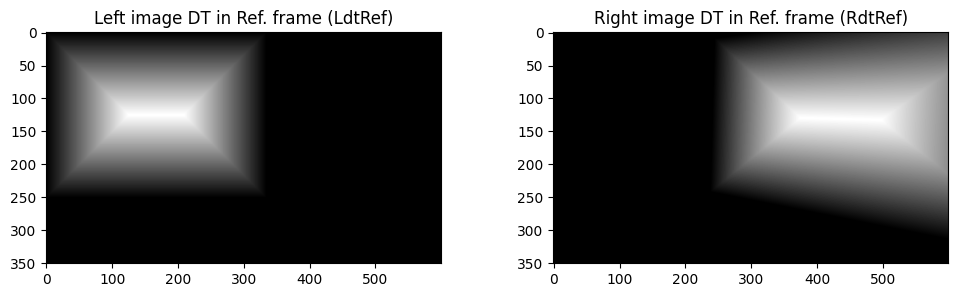

In [ ]:
left_distance = boundaryDT(imL)
right_distance = boundaryDT(imR)

warped_distanceL = warp(left_distance, tform.inverse, output_shape = (351,600))
warped_distanceR = warp(right_distance, model.inverse, output_shape = (351,600))

fig = plt.figure(4,figsize = (12, 3))
plt.subplot(121)
plt.imshow(warped_distanceL)
plt.title("Left image DT in Ref. frame (LdtRef)")

plt.subplot(122)
plt.imshow(warped_distanceR)
plt.title("Right image DT in Ref. frame (RdtRef)")

### (part c) Use boundary distance transforms to blend left and right images (reprojected) into the reference frame. Create a new figure 5 showing the following three images. The first and second images should be smooth $alpha$'s suitable for blending the left and right images (e.g. based on distance transforms as discussed in class). The third image should be your panorama: left and (reprojected) right images blended inside the reference frame. Your panorama should also show (reprojected) features - homography inliers - from both left and right images. Use different colors/shapes to distinct features from the left and the right images.

<ipython-input-142-6f0dbd4164b9>:4: RuntimeWarning: invalid value encountered in divide
  Leftalpha = warped_distanceL / (warped_distanceL + warped_distanceR)


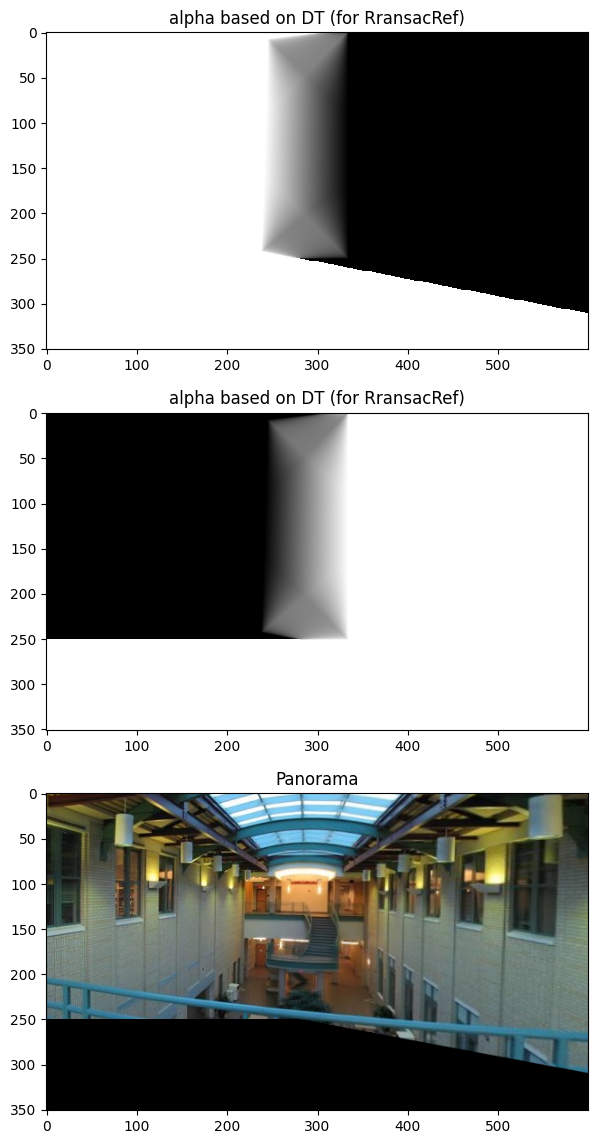

In [ ]:
warped_distanceL = warp(left_distance, tform.inverse, output_shape = (351,600))
warped_distanceR = warp(right_distance, model.inverse, output_shape = (351,600))

Leftalpha = warped_distanceL / (warped_distanceL + warped_distanceR)
Rightalpha = 1 - Leftalpha

fig = plt.figure(5,figsize = (12, 14))
plt.subplot(311)
plt.imshow(Leftalpha)
plt.title("alpha based on DT (for RransacRef)")

plt.subplot(312)
plt.imshow(Rightalpha)
plt.title("alpha based on DT (for RransacRef)")

#add a third dimension
alpha_shape = (351, 600)
Leftalpha = Leftalpha[...,np.newaxis]
Rightalpha = Rightalpha[...,np.newaxis]


tform = ProjectiveTransform(np.eye(3))
warped_imL = warp(imL, tform.inverse, output_shape = (351,600))
source = keypointsR[matchesLR[:, 1]]
destination = keypointsL[matchesLR[:, 0]]
model, inliers = ransac((np.fliplr(source),np.fliplr(destination)), ProjectiveTransform, min_samples=4, residual_threshold=3, max_trials=150)
warped_imR = warp(imR, model.inverse, output_shape = (351,600))

blend = Leftalpha * warped_imL + Rightalpha* warped_imR


plt.subplot(313)
plt.imshow(blend, cmap = 'gray')

plt.title("Panorama")

plt.show()